[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [12]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

pickup_line_subjects_prompt = "Generate a list of 3 sub-topics for pickup lines related to the overall topic: {topic}."
pickup_line_prompt = "Generate a pickup line about {subject}."
best_pickup_line_prompt = """Select the best pickup line about {topic} from the following list.
Return only the ID of the best one, where the first pickup line is ID 0. Pickup Lines: \n\n
{pickup_lines}"""
best_overall_prompt = """Below are a joke and a pickup line. Select best one overall.
Return your choice as either joke or pickup_line.

Joke: {joke}
Pickup Line: {pickup_line}
"""

model = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [13]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int

class BestPickupLine(BaseModel):
    id: int

class FinalChoice(BaseModel):
    choice: str

class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str
    pickup_line_topic: str
    pickup_line_subjects: list
    pickup_lines: Annotated[list, operator.add]
    best_selected_pickup_line: str
    final_selection: str    

Generate subjects for jokes.

In [14]:
def generate_joke_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [15]:
from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

In [16]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

In [17]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

In [18]:
def generate_pickup_line_topics(state: OverallState):
    prompt = pickup_line_subjects_prompt.format(topic=state["pickup_line_topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"pickup_line_subjects": response.subjects}

def continue_to_pickup_lines(state: OverallState):
    return [Send("generate_pickup_line", {"subject": s}) for s in state["pickup_line_subjects"]]

class PickupLineState(TypedDict):
    subject: str

def generate_pickup_line(state: PickupLineState):
    prompt = pickup_line_prompt.format(subject=state["subject"])
    response = model.invoke(prompt)
    return {"pickup_lines": [response.content]}

def best_pickup_line(state: OverallState):
    pickup_lines_string = "\\n\\n".join(state["pickup_lines"])
    prompt = best_pickup_line_prompt.format(topic=state["pickup_line_topic"], pickup_lines=pickup_lines_string)
    response = model.with_structured_output(BestPickupLine).invoke(prompt)
    return {"best_selected_pickup_line": state["pickup_lines"][response.id]}

In [19]:

def best_overall(state: OverallState):
    """Selects the best overall from best joke and best pickup line"""
    prompt = best_overall_prompt.format(
        joke=state["best_selected_joke"],
        pickup_line=state["best_selected_pickup_line"]
    )
    response = model.with_structured_output(FinalChoice).invoke(prompt)
    
    if response.choice == "joke":
        selection = state["best_selected_joke"]
    else:
        selection = state["best_selected_pickup_line"]
        
    return {"final_selection": selection}

## Compile

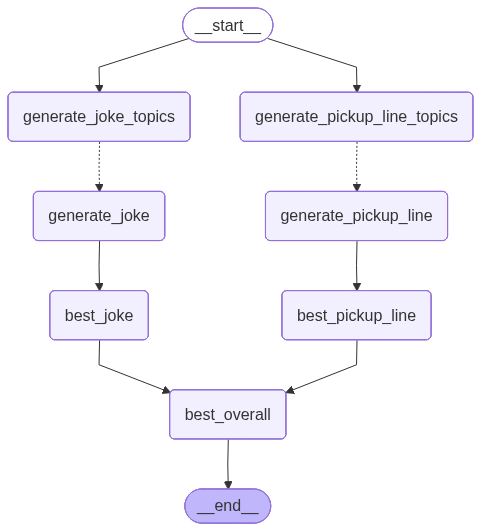

In [20]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

graph = StateGraph(OverallState)
graph.add_node("generate_joke_topics", generate_joke_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_node("generate_pickup_line_topics", generate_pickup_line_topics)
graph.add_node("generate_pickup_line", generate_pickup_line)
graph.add_node("best_pickup_line", best_pickup_line)
graph.add_node("best_overall", best_overall)

graph.add_edge(START, "generate_joke_topics")
graph.add_edge(START, "generate_pickup_line_topics")

graph.add_conditional_edges("generate_joke_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")

graph.add_conditional_edges("generate_pickup_line_topics", continue_to_pickup_lines, ["generate_pickup_line"])
graph.add_edge("generate_pickup_line", "best_pickup_line")

graph.add_edge("best_joke", "best_overall")
graph.add_edge("best_pickup_line", "best_overall")
graph.add_edge("best_overall", END)

app = graph.compile()

Image(app.get_graph().draw_mermaid_png())

In [29]:
# Define the inputs for both branches
inputs = {"topic": "animals", "pickup_line_topic": "computer science"}
events = []
for s in app.stream(inputs):
    print(s)
    print(" ")
    events.append(s)


{'generate_pickup_line_topics': {'pickup_line_subjects': ['Programming Languages', 'Algorithms and Data Structures', 'Artificial Intelligence and Machine Learning']}}
 
{'generate_joke_topics': {'subjects': ['Animal Behavior', 'Endangered Species Conservation', 'Animal Habitats and Ecosystems']}}
 
{'generate_joke': {'jokes': ['Why did the chicken join a band? \n\nBecause it had the drumsticks!']}}
 
{'generate_pickup_line': {'pickup_lines': ['"Are you a neural network? Because you’ve got my heart training on a whole new level!"']}}
 
{'generate_pickup_line': {'pickup_lines': ['"Are you an algorithm? Because you\'ve got me sorting through my feelings and searching for the right way to your heart!"']}}
 
{'generate_joke': {'jokes': ["Why did the fish blush? \n\nBecause it saw the ocean's bottom!"]}}
 
{'generate_joke': {'jokes': ['Why did the endangered species break up with its partner? \n\nBecause they needed more space to thrive!']}}
 
{'generate_pickup_line': {'pickup_lines': ['"Are

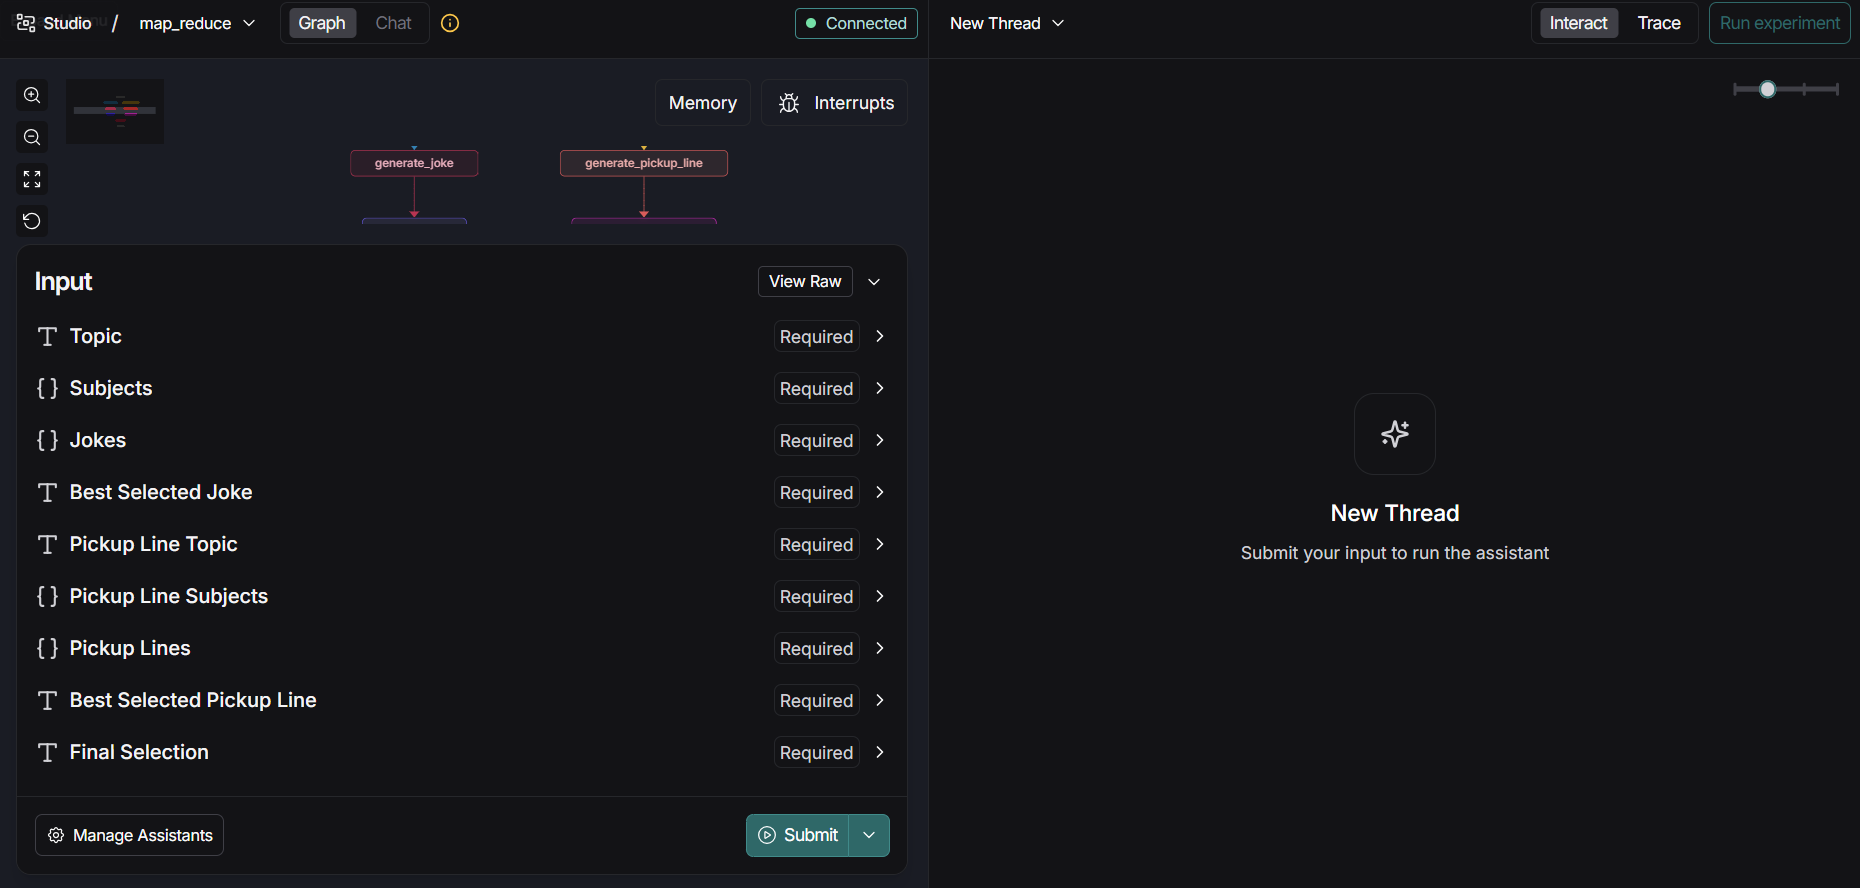